<a href="https://colab.research.google.com/github/vishnubharadwaj1234/AI-Generated-Faces/blob/main/FacesProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd "/content/drive/Othercomputers/My MacBook Pro/"

/content/drive/Othercomputers/My MacBook Pro


In [ ]:
!ls

fake_faces_70k	real_faces_128


Working model of Resent 34 with 25000 samples

Streaming output truncated to the last 5000 lines.
Read real face: 20030
Read real face: 20031
Read real face: 20032
Read real face: 20033
Read real face: 20034
Read real face: 20035
Read real face: 20036
Read real face: 20037
Read real face: 20038
Read real face: 20039
Read real face: 20040
Read real face: 20041
Read real face: 20042
Read real face: 20043
Read real face: 20044
Read real face: 20045
Read real face: 20046
Read real face: 20047
Read real face: 20048
Read real face: 20049
Read real face: 20050
Read real face: 20051
Read real face: 20052
Read real face: 20053
Read real face: 20054
Read real face: 20055
Read real face: 20056
Read real face: 20057
Read real face: 20058
Read real face: 20059
Read real face: 20060
Read real face: 20061
Read real face: 20062
Read real face: 20063
Read real face: 20064
Read real face: 20065
Read real face: 20066
Read real face: 20067
Read real face: 20068
Read real face: 20069
Read real face: 20070
Read real face: 20071
Read real face: 20072
Rea

Model training completed and saved!


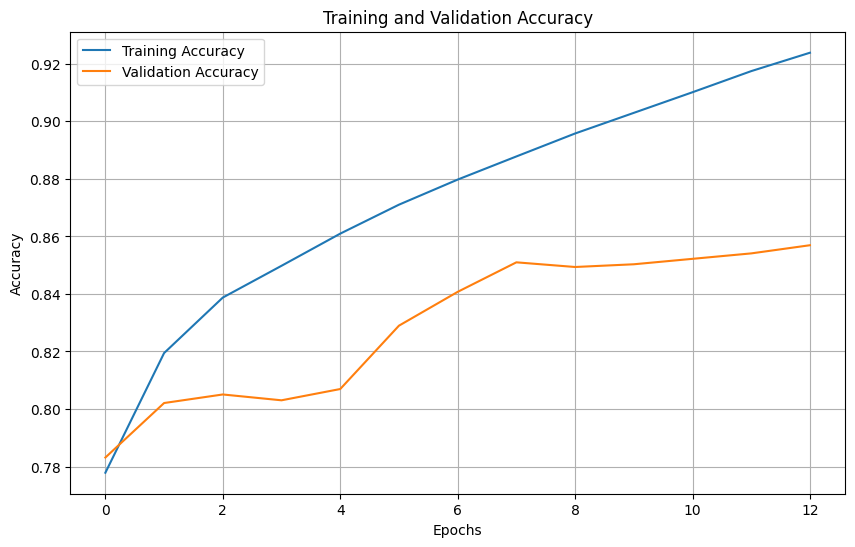

In [ ]:
#Working ResNet with 25000 sampless
import os
import numpy as np
from tensorflow.keras.applications import ResNet50  # Using ResNet50 as a proxy for ResNet34 in Keras
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import tensorflow as tf

# Check if GPU is available
device_name = tf.test.gpu_device_name()
if device_name:
    print(f"GPU is available: {device_name}")
else:
    print("GPU not found. Ensure that GPU is enabled in Colab.")

# Path to the dataset
base_path = '/content/drive/Othercomputers/My MacBook Pro/'

# Folder names
fake_faces_folder = "fake_faces_70k"
real_faces_folder = "real_faces_128"

# Image dimensions and parameters
img_height, img_width = 224, 224
fake_label = -1
real_label = 1
fake_count_limit = 25000
real_count_limit = 25000

# Collect image paths and labels
image_paths = []
labels = []

# Read fake faces
fake_faces_path = os.path.join(base_path, fake_faces_folder)
fake_count = 0
for img_name in os.listdir(fake_faces_path):
    if fake_count >= fake_count_limit:
        break
    image_paths.append(os.path.join(fake_faces_path, img_name))
    labels.append(fake_label)
    fake_count += 1
    print(f"Read fake face: {fake_count}")

# Read real faces
real_faces_path = os.path.join(base_path, real_faces_folder)
real_count = 0
for img_name in os.listdir(real_faces_path):
    if real_count >= real_count_limit:
        break
    image_paths.append(os.path.join(real_faces_path, img_name))
    labels.append(real_label)
    real_count += 1
    print(f"Read real face: {real_count}")

# Convert labels to categorical and normalize them to [0, 1]
labels = np.array(labels)
labels[labels == -1] = 0  # Convert -1 to 0 for binary classification

# Split data into train and validation sets
from sklearn.model_selection import train_test_split
train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42
)

# Data generator for loading and preprocessing
datagen = ImageDataGenerator(rescale=1.0 / 255.0)

def load_image(image_path):
    """
    Helper function to load and preprocess a single image.
    """
    from tensorflow.keras.preprocessing.image import load_img, img_to_array
    img = load_img(image_path, target_size=(img_height, img_width))
    return img_to_array(img)

def data_generator(image_paths, labels, batch_size=32):
    """
    Generator for loading images and labels.
    """
    while True:
        for i in range(0, len(image_paths), batch_size):
            batch_paths = image_paths[i:i + batch_size]
            batch_labels = labels[i:i + batch_size]
            batch_images = np.array([load_image(img) for img in batch_paths])
            yield batch_images, np.array(batch_labels)

# Generators for training and validation
batch_size = 32
train_gen = data_generator(train_paths, train_labels, batch_size)
val_gen = data_generator(val_paths, val_labels, batch_size)

# Build the ResNet34 model
base_model = tf.keras.applications.ResNet50(weights="imagenet", include_top=False, input_shape=(img_height, img_width, 3))  # ResNet50 is closest to ResNet34

# Freeze the base model
base_model.trainable = False

# Add custom layers for binary classification
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Replace Flatten with GAP
x = Dense(256, activation="relu")(x)
predictions = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Train the model
steps_per_epoch = len(train_paths) // batch_size
validation_steps = len(val_paths) // batch_size

early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

with tf.device('/GPU:0'):  # Ensure the model runs on GPU
    history = model.fit(
        train_gen,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_gen,
        validation_steps=validation_steps,
        epochs=50,
        callbacks=[early_stopping]
    )

# Save the trained model
model.save("/content/drive/MyDrive/AIGeneratedFacesProject/resnet34_faces_classifier.h5")
print("Model training completed and saved!")

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()




Efficient Net B0 and its performance

GPU Status: /device:GPU:0
Epoch 1/100
929/929 ━━━━━━━━━━━━━━━━━━━━ 28586s 31s/step - accuracy: 0.6738 - loss: 0.6346 - val_accuracy: 0.6689 - val_loss: 0.6366 - learning_rate: 1.0000e-04
Epoch 2/100
929/929 ━━━━━━━━━━━━━━━━━━━━ 466s 492ms/step - accuracy: 0.6733 - loss: 0.6330 - val_accuracy: 0.6686 - val_loss: 0.6359 - learning_rate: 1.0000e-04
Epoch 3/100
929/929 ━━━━━━━━━━━━━━━━━━━━ 455s 490ms/step - accuracy: 0.6719 - loss: 0.6338 - val_accuracy: 0.6689 - val_loss: 0.6361 - learning_rate: 1.0000e-04
Epoch 4/100
929/929 ━━━━━━━━━━━━━━━━━━━━ 456s 492ms/step - accuracy: 0.6718 - loss: 0.6338 - val_accuracy: 0.6682 - val_loss: 0.6361 - learning_rate: 1.0000e-04
Epoch 5/100
929/929 ━━━━━━━━━━━━━━━━━━━━ 442s 477ms/step - accuracy: 0.6715 - loss: 0.6338 - val_accuracy: 0.6687 - val_loss: 0.6355 - learning_rate: 1.0000e-04
Epoch 6/100
929/929 ━━━━━━━━━━━━━━━━━━━━ 430s 463ms/step - accuracy: 0.6718 - loss: 0.6336 - val_accuracy: 0.6685 - val_loss: 0.6354 - learning_rate: 1.0000e-04
Epoch 7/

Model training completed and saved!


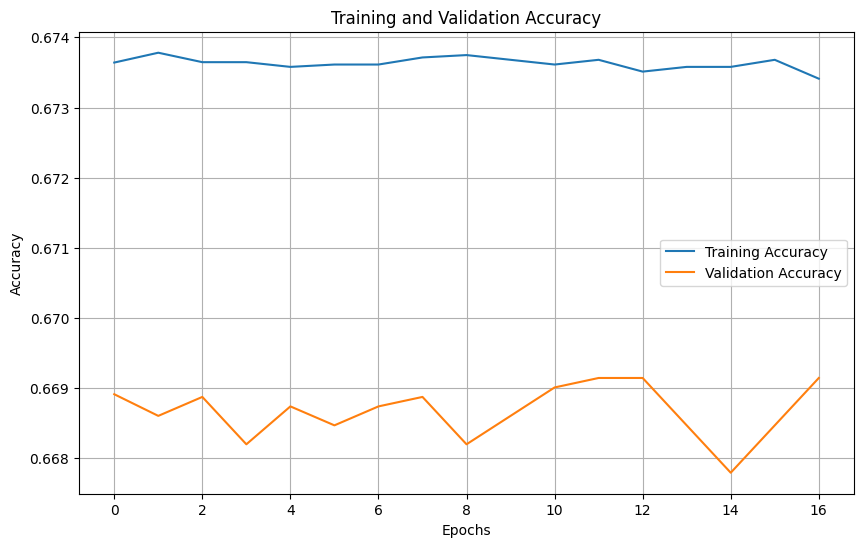

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# GPU Check
device_name = tf.test.gpu_device_name()
print(f"GPU Status: {device_name if device_name else 'No GPU found!'}")

# Paths
base_path = '/content/drive/Othercomputers/My MacBook Pro/'
fake_faces_folder = "fake_faces_70k"
real_faces_folder = "real_faces_128"

# Parameters
img_height, img_width = 224, 224
fake_label, real_label = 0, 1
fake_count_limit, real_count_limit = 25000, 25000

# Collect Image Paths and Labels
image_paths, labels = [], []

# Read Images
for folder, label, count_limit in zip(
    [fake_faces_folder, real_faces_folder],
    [fake_label, real_label],
    [fake_count_limit, real_count_limit],
):
    folder_path = os.path.join(base_path, folder)
    count = 0
    for img_name in os.listdir(folder_path):
        if count >= count_limit:
            break
        image_paths.append(os.path.join(folder_path, img_name))
        labels.append(label)
        count += 1

# Convert Labels to Array
labels = np.array(labels)

# Split Dataset
train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42
)

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
)
val_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

def data_generator(image_paths, labels, batch_size, is_training=True):
    datagen = train_datagen if is_training else val_datagen
    while True:
        for i in range(0, len(image_paths), batch_size):
            batch_paths = image_paths[i:i + batch_size]
            batch_labels = labels[i:i + batch_size]
            batch_images = []
            for img_path in batch_paths:
                # Load and preprocess the image
                img = load_img(img_path, target_size=(img_height, img_width))
                img_array = img_to_array(img)
                img_array = np.expand_dims(img_array, axis=0)

                # Use next() to retrieve the augmented image
                augmented_img = next(datagen.flow(img_array, batch_size=1))[0]
                batch_images.append(augmented_img)

            yield np.array(batch_images), np.array(batch_labels)


# Datasets
batch_size = 32
train_gen = data_generator(train_paths, train_labels, batch_size)
val_gen = data_generator(val_paths, val_labels, batch_size)

# Build Model
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = False  # Freeze

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
predictions = Dense(1, activation="sigmoid")(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

# Callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=3, min_lr=1e-6)

# Train Model
with tf.device('/GPU:0'):
    history = model.fit(
        train_gen,
        steps_per_epoch=len(train_paths) // batch_size,
        validation_data=val_gen,
        validation_steps=len(val_paths) // batch_size,
        epochs=100,
        callbacks=[early_stopping, reduce_lr],
    )

# Fine-tune: Unfreeze Last Few Layers
for layer in base_model.layers[-20:]:
    layer.trainable = True
model.compile(optimizer=Adam(learning_rate=1e-5), loss="binary_crossentropy", metrics=["accuracy"])

with tf.device('/GPU:0'):
    fine_tune_history = model.fit(
        train_gen,
        steps_per_epoch=len(train_paths) // batch_size,
        validation_data=val_gen,
        validation_steps=len(val_paths) // batch_size,
        epochs=20,
        callbacks=[early_stopping, reduce_lr],
    )

# Save Model
model.save("/content/drive/MyDrive/AIGeneratedFacesProject/efficientnet_faces_classifier.h5")
print("Model training completed and saved!")

# Plot Accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


Efficient Net B0 and its performance without the data augmentation

GPU Status: /device:GPU:0
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/100
929/929 ━━━━━━━━━━━━━━━━━━━━ 24248s 26s/step - accuracy: 0.7287 - loss: 0.5371 - val_accuracy: 0.7829 - val_loss: 0.4612 - learning_rate: 1.0000e-04
Epoch 2/100
929/929 ━━━━━━━━━━━━━━━━━━━━ 130s 130ms/step - accuracy: 0.7910 - loss: 0.4450 - val_accuracy: 0.7988 - val_loss: 0.4329 - learning_rate: 1.0000e-04
Epoch 3/100
929/929 ━━━━━━━━━━━━━━━━━━━━ 113s 122ms/step - accuracy: 0.8044 - loss: 0.4222 - val_accuracy: 0.8080 - val_loss: 0.4167 - learning_rate: 1.0000e-04
Epoch 4/100
929/929 ━━━━━━━━━━━━━━━━━━━━ 108s 117ms/step - accuracy: 0.8186 - loss: 0.4078 - val_accuracy: 0.8137 - val_loss: 0.4062 - learning_rate: 1.0000e-04
Epoch 5/100
929/929 ━━━━━━━━━━━━━━━━━━━━ 107s 115ms/step - accuracy: 0.8227 - loss: 0.3945 - val_accuracy: 0.8211 - val_loss: 0.3967 - learning_rate: 1.0000e-04
Epoch 6/100
929/929 ━━━━━━━━━━━━━━━━━━━━ 107s 115ms/step - accuracy: 0.8306 - loss: 0.3798 - val_accuracy: 0.8257 - va

Model training completed and saved!


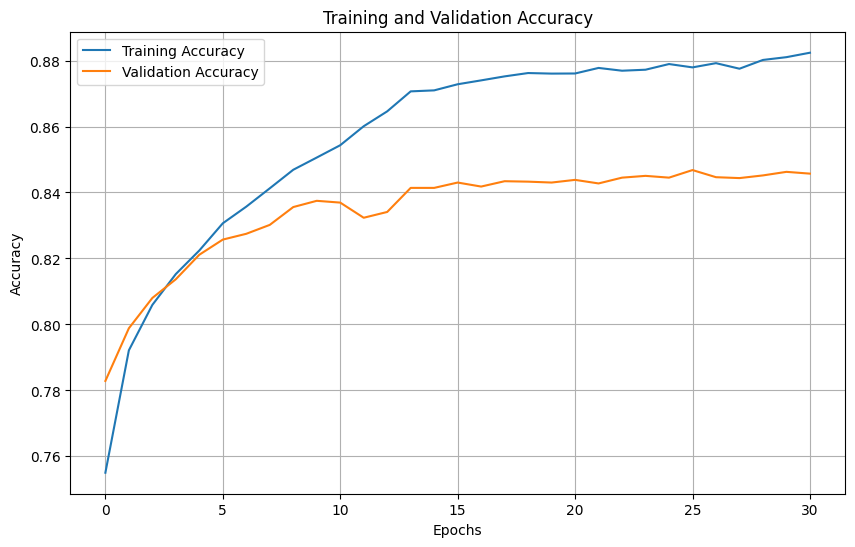

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# GPU Check
device_name = tf.test.gpu_device_name()
print(f"GPU Status: {device_name if device_name else 'No GPU found!'}")

# Paths
base_path = '/content/drive/Othercomputers/My MacBook Pro/'
fake_faces_folder = "fake_faces_70k"
real_faces_folder = "real_faces_128"

# Parameters
img_height, img_width = 224, 224
fake_label, real_label = 0, 1
fake_count_limit, real_count_limit = 25000, 25000

# Collect Image Paths and Labels
image_paths, labels = [], []

# Read Images
for folder, label, count_limit in zip(
    [fake_faces_folder, real_faces_folder],
    [fake_label, real_label],
    [fake_count_limit, real_count_limit],
):
    folder_path = os.path.join(base_path, folder)
    count = 0
    for img_name in os.listdir(folder_path):
        if count >= count_limit:
            break
        image_paths.append(os.path.join(folder_path, img_name))
        labels.append(label)
        count += 1

# Convert Labels to Array
labels = np.array(labels)

# Split Dataset
train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42
)

# Data Augmentation
train_datagen = ImageDataGenerator(

    rotation_range=00,
    width_shift_range=0.0,
    height_shift_range=0.0,
    shear_range=0.0,
    zoom_range=0.0
)
val_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

def data_generator(image_paths, labels, batch_size, is_training=True):
    datagen = train_datagen if is_training else val_datagen
    while True:
        for i in range(0, len(image_paths), batch_size):
            batch_paths = image_paths[i:i + batch_size]
            batch_labels = labels[i:i + batch_size]
            batch_images = []
            for img_path in batch_paths:
                # Load and preprocess the image
                img = load_img(img_path, target_size=(img_height, img_width))
                img_array = img_to_array(img)
                img_array = np.expand_dims(img_array, axis=0)

                # Use next() to retrieve the augmented image
                augmented_img = next(datagen.flow(img_array, batch_size=1))[0]
                batch_images.append(augmented_img)

            yield np.array(batch_images), np.array(batch_labels)


# Datasets
batch_size = 32
train_gen = data_generator(train_paths, train_labels, batch_size)
val_gen = data_generator(val_paths, val_labels, batch_size)

# Build Model
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = False  # Freeze

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
predictions = Dense(1, activation="sigmoid")(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

# Callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=3, min_lr=1e-6)

# Train Model
with tf.device('/GPU:0'):
    history = model.fit(
        train_gen,
        steps_per_epoch=len(train_paths) // batch_size,
        validation_data=val_gen,
        validation_steps=len(val_paths) // batch_size,
        epochs=100,
        callbacks=[early_stopping, reduce_lr],
    )

# Fine-tune: Unfreeze Last Few Layers
for layer in base_model.layers[-20:]:
    layer.trainable = True
model.compile(optimizer=Adam(learning_rate=1e-5), loss="binary_crossentropy", metrics=["accuracy"])

with tf.device('/GPU:0'):
    fine_tune_history = model.fit(
        train_gen,
        steps_per_epoch=len(train_paths) // batch_size,
        validation_data=val_gen,
        validation_steps=len(val_paths) // batch_size,
        epochs=20,
        callbacks=[early_stopping, reduce_lr],
    )

# Save Model
model.save("/content/drive/MyDrive/AIGeneratedFacesProject/efficientnet_faces_classifier.h5")
print("Model training completed and saved!")

# Plot Accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()
